In [37]:
import dataclasses
from collections.abc import Iterator, Mapping
from types import MappingProxyType
from typing import Any, Literal, Optional

import jax
import jax.numpy as jnp
import sklearn
import sklearn.datasets

import optax

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott import datasets
from ott.geometry import costs, pointcloud

from ott.tools import sinkhorn_divergence

import jax
import jax.numpy as jnp
from ott.geometry.geometry import Geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
import scipy
import numpy as np

from typing import Any, Optional

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib import colors

from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers import linear
from ott.tools import progot
import scipy

import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
sys.path.insert(0, '../src/')
import importlib
import FRLC
from FRLC import FRLC_opt
import HR_OT
importlib.reload(HR_OT)

<module 'HR_OT' from '/home/ph3641/HierarchicalRefinement/HR_OT/HR_OT/notebooks/../src/HR_OT.py'>

In [38]:
global n_points;

n_points = 1024 #4096

In [39]:
def plot_eval_samples(
    eval_data_source, eval_data_target, transported_samples=None
):
    fig, axs = plt.subplots(
        1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0, "hspace": 0}
    )
    axs[0].scatter(
        eval_data_source[:, 0],
        eval_data_source[:, 1],
        color="#A7BED3",
        s=10,
        alpha=0.5,
        label="source",
    )
    axs[0].set_title("Source measure samples")
    axs[1].scatter(
        eval_data_target[:, 0],
        eval_data_target[:, 1],
        color="#1A254B",
        s=10,
        alpha=0.5,
        label="target",
    )
    axs[1].set_title("Target measure samples")

    if transported_samples is not None:
        axs[1].scatter(
            transported_samples[:, 0],
            transported_samples[:, 1],
            color="#F2545B",
            s=10,
            alpha=0.5,
            label="pushforward of source",
        )

    fig.legend(
        **{
            "ncol": (3 if transported_samples is not None else 2),
            "loc": "upper center",
            "bbox_to_anchor": (0.5, 0.1),
            "edgecolor": "k",
        }
    )

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    return fig, ax

@dataclasses.dataclass
class MAFMoonSampler:
    size: int

    def __iter__(self):
        rng = jax.random.key(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        x = jax.random.normal(key, shape=[batch_size, 2])
        x = x.at[:, 0].add(x[:, 1] ** 2)
        x = x.at[:, 0].mul(0.5)
        x = x.at[:, 0].add(-5)
        return x


@dataclasses.dataclass
class RingSampler:
    size: int

    def __iter__(self):
        rng = jax.random.key(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        n_samples4 = n_samples3 = n_samples2 = batch_size // 4
        n_samples1 = batch_size - n_samples4 - n_samples3 - n_samples2

        linspace4 = jnp.linspace(0, 2 * jnp.pi, n_samples4, endpoint=False)
        linspace3 = jnp.linspace(0, 2 * jnp.pi, n_samples3, endpoint=False)
        linspace2 = jnp.linspace(0, 2 * jnp.pi, n_samples2, endpoint=False)
        linspace1 = jnp.linspace(0, 2 * jnp.pi, n_samples1, endpoint=False)

        circ4_x = jnp.cos(linspace4) * 1.2
        circ4_y = jnp.sin(linspace4) * 1.2
        circ3_x = jnp.cos(linspace4) * 0.9
        circ3_y = jnp.sin(linspace3) * 0.9
        circ2_x = jnp.cos(linspace2) * 0.55
        circ2_y = jnp.sin(linspace2) * 0.55
        circ1_x = jnp.cos(linspace1) * 0.25
        circ1_y = jnp.sin(linspace1) * 0.25

        X = (
            jnp.vstack(
                [
                    jnp.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
                    jnp.hstack([circ4_y, circ3_y, circ2_y, circ1_y]),
                ]
            ).T
            * 3.0
        )
        X = sklearn.utils.shuffle(X)

        # Add noise
        X = X + jax.random.normal(key, shape=X.shape) * 0.08

        return X.astype("float32")

@dataclasses.dataclass
class SklearnDistribution:
    name: Literal["moon", "s_curve"]
    theta_rotation: float = 0.0
    mean: Optional[jnp.ndarray] = None
    noise: float = 0.01
    scale: float = 1.0
    batch_size: int = 1024
    rng: Optional[jax.Array] = None

    def __iter__(self) -> Iterator[jnp.ndarray]:
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = jax.random.key(0) if self.rng is None else self.rng
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=(self.batch_size, 0),
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                x, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = x[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            mean = jnp.zeros(2) if self.mean is None else self.mean
            samples = mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = n_points,
    valid_batch_size: int = n_points,
    rng: Optional[jax.Array] = None,
):
    rng = jax.random.key(0) if rng is None else rng
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data

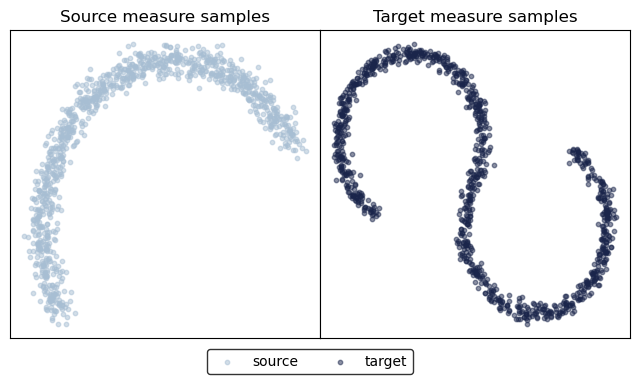

In [44]:
experiment = 'halfmoon_Scurve' #'maf_moon_ring'

if experiment == 'checkerboard':

    num_samples_visualize = n_points
    (
        train_dataloaders,
        valid_dataloaders,
        input_dim,
    ) = datasets.create_gaussian_mixture_samplers(
        name_source="square_five",
        name_target="square_four",
        valid_batch_size=num_samples_visualize,
        train_batch_size=2048,
    )
    
    eval_data_source = next(valid_dataloaders.source_iter)
    eval_data_target = next(valid_dataloaders.target_iter)
    
    eval_data_source = next(valid_dataloaders.source_iter)
    eval_data_target = next(valid_dataloaders.target_iter)

elif experiment == 'maf_moon_ring':
    
    train_loader = datasets.Dataset(
    source_iter=iter(MAFMoonSampler(size=n_points)),
    target_iter=iter(RingSampler(size=n_points)),
    )
    valid_loader = train_loader
    
    eval_data_source = next(train_loader.source_iter)
    eval_data_target = next(train_loader.target_iter)

elif experiment == 'halfmoon_Scurve':

    train_dataset, valid_dataset, dim_data = create_samplers(
    source_kwargs={
        "name": "moon",
        "theta_rotation": jnp.pi / 6,
        "mean": jnp.array([0.0, -0.5]),
        "noise": 0.05,
    },
    target_kwargs={
        "name": "s_curve",
        "scale": 0.6,
        "mean": jnp.array([0.5, -2.0]),
        "theta_rotation": -jnp.pi / 6,
        "noise": 0.05,
        },
    )
    eval_data_source = next(train_dataset.source_iter)
    eval_data_target = next(train_dataset.target_iter)

fig, ax = plot_eval_samples(eval_data_source, eval_data_target)
display(fig)
plt.close(fig)


# Evaluation against Sinkhorn

In [45]:
import statistics
importlib.reload(HR_OT)

@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)
    
    _, out = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    
    return out.divergence


def run_progot(
    x: jnp.ndarray, y: jnp.ndarray, cost_fn: costs.TICost, **kwargs: Any
) -> progot.ProgOTOutput:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    prob = linear_problem.LinearProblem(geom)
    estim = progot.ProgOT(**kwargs)
    out = estim(prob)
    return out

K = 4
cost_fn = costs.SqEuclidean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

# Squared Euclidean cost p=2 or Euclidean if p=1
p = 2

# Define pairwise Dist Mat
X, Y = torch.tensor(np.array(eval_data_source)).type(torch.DoubleTensor).to(device), \
                    torch.tensor(np.array(eval_data_target)).type(torch.DoubleTensor).to(device)

C = torch.cdist( X, Y ) ** p
C = C / C.max()

rank_schedule = [ 32, 32 ] #[ 32, 32 ]

P = HR_OT.hierarchical_refinement(torch.tensor(C), \
                                  torch.tensor(rank_schedule), FRLC_opt, \
                                  device=device, base_rank=1,
                                 return_as_coupling=True)

cost_hr_ot = torch.sum( C.to(device) * P.to(device) )

'''
Sinkhorn Sol'n
'''

geom = Geometry( C.cpu().numpy() )
ot_problem = linear_problem.LinearProblem(geom)
solver = sinkhorn.Sinkhorn()
ot_solution = solver(ot_problem)
P_sinkhorn = ot_solution.matrix

'''
ProgOT Sol'n
'''

x_train, y_train = eval_data_source, eval_data_target 

alphas = progot.get_alpha_schedule("exp", num_steps=K)

out = run_progot(eval_data_source, eval_data_target, \
                 cost_fn, alphas=alphas, \
                 epsilons=None)

xs, ys = out.transport(eval_data_source, return_intermediate=False)

P_progOT_default = out.get_output(-1).matrix

cost_Sinkhorn = np.sum( C.cpu().numpy() * P_sinkhorn )
cost_prog_default = np.sum( C.cpu().numpy() * P_progOT_default )

'''
end_epsilon_scales = jnp.logspace(-10, -9, 4, base=2)
geom = pointcloud.PointCloud(
    x_train, y_train, cost_fn=cost_fn
)

tuned_epsilons = progot.get_epsilon_schedule(
    geom,
    alphas=alphas,
    epsilon_scales=end_epsilon_scales,
    start_epsilon_scale=0.5,
    y_eval=y_train,
)

out_tuned = run_progot(
    x_train, y_train, cost_fn, alphas=alphas, epsilons=tuned_epsilons
)

P_progOT_tuned = out_tuned.get_output(-1).matrix
cost_prog_tuned = (P_progOT_tuned * C).sum()
'''

'''
compute deterministic costs
'''

if p == 2:
    print(f'Comparing costs for p={p}, Sinkhorn: {cost_Sinkhorn} Default ProgOT { \
                                    cost_prog_default}, Hierarchical-refinement: {cost_hr_ot}')
elif p == 1:
    print(f'Comparing costs for p={p}, Sinkhorn: {cost_Sinkhorn}, Hierarchical-refinement: {cost_hr_ot}')


On device: cpu
Iteration: 0


/tmp/ipykernel_1613022/2288978053.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P = HR_OT.hierarchical_refinement(torch.tensor(C), \


Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Comparing costs for p=2, Sinkhorn: 0.3478621542453766 Default ProgOT 0.3442690372467041, Hierarchical-refinement: 0.3553308735945291


In [46]:
print(scipy.stats.entropy(P_sinkhorn.flatten()))
print(scipy.stats.entropy(P_progOT_default.flatten()))
print(scipy.stats.entropy(P.flatten()))

print( np.sum( P_sinkhorn > 1e-8 ) )
print( np.sum( P_progOT_default > 1e-8 ) )
print( np.sum( P.numpy() > 1e-8 ) )

12.77761
12.117033
6.931462
652993
337258
1024


In [1]:
'''
# Barycentric projection on Target (Sinkhorn)
pred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=1)) @ P_sinkhorn @ eval_data_target

print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_loss(pred_target_sinkhorn, eval_data_target):.2f}"
)

# Barycentric projection on Source (Sinkhorn)
pred_source = np.diag(1 / np.sum(P_sinkhorn, axis=1)) @ P_sinkhorn.T @ eval_data_source

print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")
'''

'''
for idx1 in range(P.shape[0]):
    idx2 = int(np.argmax(P[idx1, :])) # only 1 index
    x_values = eval_data_source[idx1, 0], eval_data_target[idx2, 0]
    y_values = eval_data_source[idx1, 1], eval_data_target[idx2, 1]
    plt.plot(x_values, y_values, c='black')

plt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Set A', alpha=0.5)
plt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Set B', alpha=0.5)

#plt.savefig('example_sparse.png')
plt.show()

pred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=0)) @ P_sinkhorn @ eval_data_target

for idx1 in range(P_sinkhorn.shape[0]):
    x_values = X[idx1, 0], pred_target_sinkhorn[idx1, 0]
    y_values = X[idx1, 1], pred_target_sinkhorn[idx1, 1]
    plt.plot(x_values, y_values, c='black')

plt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Initial points', alpha=0.5)
plt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Final points', alpha=0.5)
plt.scatter(pred_target_sinkhorn[:,0], pred_target_sinkhorn[:,1], c='y', label=r'Barycentric projection', alpha=0.5)

#plt.savefig('example_sparse.png')
plt.show()
'''

"\nfor idx1 in range(P.shape[0]):\n    idx2 = int(np.argmax(P[idx1, :])) # only 1 index\n    x_values = eval_data_source[idx1, 0], eval_data_target[idx2, 0]\n    y_values = eval_data_source[idx1, 1], eval_data_target[idx2, 1]\n    plt.plot(x_values, y_values, c='black')\n\nplt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Set A', alpha=0.5)\nplt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Set B', alpha=0.5)\n\n#plt.savefig('example_sparse.png')\nplt.show()\n\npred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=0)) @ P_sinkhorn @ eval_data_target\n\nfor idx1 in range(P_sinkhorn.shape[0]):\n    x_values = X[idx1, 0], pred_target_sinkhorn[idx1, 0]\n    y_values = X[idx1, 1], pred_target_sinkhorn[idx1, 1]\n    plt.plot(x_values, y_values, c='black')\n\nplt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Initial points', alpha=0.5)\nplt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Final point